In this notebook I will analyze the patents about electrically debondable adhesives form Henkel.

In [1]:
# Imports 

# Own Packages
from Masterarbeit_utils.model_utils_agg import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer

# Site Packages
import pandas as pd
import numpy as np
import pickle as pk
import torch
import os 
import sys
import psutil
from collections import Counter
import itertools
import matplotlib.pyplot as plt
# Dimension reduction algorithms
#from cuml.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.spatial import distance
from scipy.fft import fft, fftfreq
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import export_png
from bokeh.palettes import Viridis256, Category20
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.colors import RGB

# Huggingface
from transformers import AutoTokenizer, OPTForCausalLM
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset

output_notebook()

2023-12-04 12:38:56.061529: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 12:38:56.083884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 12:38:56.690798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading BokehJS ...

In [2]:
###########################################################
# Loading the Henkel Patents
###########################################################

# Directories in which data important for the notebook is stored
dump_dir = 'PK_DUMP'
data_dir = 'data'

# Loading the dataframes with the patents deemed most important for electrically debondable adhesives from Henkel
henkel_patents = pd.read_csv(f'{data_dir}/Henkel_patente_patstat_docdb_families_abstract.csv', delimiter=',').reset_index(drop=True)
henkel_orbit = pd.read_csv(f'{data_dir}/Henkel_Orbit_Suche_Patstat_Export.csv', delimiter=',')

# Filtering the Samples which contain F-Terms
henkel_filtered = henkel_patents[henkel_patents['fterms'].notna()]
henkel_filtered = henkel_filtered.reset_index(drop=True)

orbit_filtered = henkel_orbit[henkel_orbit['fterms'].notna()]
orbit_filtered = orbit_filtered.reset_index(drop=True)

print(f"There are {len(henkel_patents['doc_db_family_id'].unique())} unique patents in the Henkel dataset, only {len(henkel_filtered['doc_db_family_id'].unique())} of them contain F-Terms.")

# extracting all f-terms form the datasets
fterms_henkel = [fterm[:10] for fterms in henkel_filtered['fterms'] for fterm in fterms.split(',')]
fterms_orbit = [fterm[:10] for fterms in orbit_filtered['fterms'] for fterm in fterms.split(',')]

# Aggreagting the F-Terms
with open(f'{dump_dir}/aggregation_dict_new.pk', 'rb') as f:
    aggregation_dict = pk.load(f)

def aggregate(f_term):
    try:
        return aggregation_dict[f_term]
    except KeyError:
        pass

fterms_henkel_agg = [aggregate(fterm) for fterm in fterms_henkel if aggregate(fterm) is not None]
fterms_orbit_agg = [aggregate(fterm) for fterm in fterms_orbit if aggregate(fterm) is not None]

# Counting the occurrences of the henkel and orbit fterms
counter_henkel = Counter(fterms_henkel_agg)
counter_orbit = Counter(fterms_orbit_agg)

# Structuring the henkel F-Terms
henkel_dict = {}
for fterm in counter_henkel.keys():
    theme = fterm[:5]
    try:
        _ = henkel_dict[theme]
    except KeyError:
        henkel_dict[theme] = {}

    vp = fterm[:8]
    try: 
        henkel_dict[theme][vp].append(fterm)
    except KeyError:
        henkel_dict[theme][vp] = [fterm]

# Extracting the themes/viewpoints/ and unique fterms form the F-Terms

henkel_themes = list(set([fterm[:5] for fterm in fterms_henkel_agg]))
orbit_themes = list(set([fterm[:5] for fterm in fterms_orbit_agg]))

henkel_viewpoints = list(set([fterm[:8] for fterm in fterms_henkel_agg]))
orbit_viewpoints = list(set([fterm[:8] for fterm in fterms_orbit_agg]))

henkel_fterms = list(set(fterms_henkel_agg))
orbit_fterms = list(set(fterms_orbit_agg))
################################################################
# Loading the Model
################################################################

model_name = 'gal_125_new_1'
checkpoint = 173030
# If True normalization is applied to the embeddings
norm = True
context_less = False

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
if model_name.split('_')[1] == '125':
    base_model_name = 'mini'
elif model_name.split('_')[1] == '1300':
    base_model_name = 'base'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
default_device = 'cpu'

# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False


###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available

model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms:,} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/agg_themes_descriptions_new.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/agg_viewpoints_descriptions_new.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/agg_numbers_descriptions_new.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/agg_full_descriptions_new.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)


###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()


#Embeddings if the model is not a sequence classification model
out_emb = model.get_output_embeddings()
out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]

if context_less:
    # Extracting context less embeddings
    if not os.path.isfile(f'{model_folder}/context_less_emb{checkpoint}.pk'):
        print('Calculating context less embeddings!')
        context_less_emb = [[] for _ in range(len([1 for _ in model.parameters()]))]
        for i in range(len(tokenizer)):
            print(i, end='\r')
            out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
                
            out = out.hidden_states
            for i, k in enumerate(out):
                context_less_emb[i].append(k.to('cpu').detach().numpy())
        with open(f'{model_folder}/context_less_emb{checkpoint}.pk', 'wb') as f:
            pk.dump(context_less_emb, f)
    else:
        print('Loading context less embeddings from disk')
        with open(f'{model_folder}/context_less_emb{checkpoint}.pk', 'rb') as f:
            context_less_emb = pk.load(f)
        
    # Combining context less embeddings of a layer to a single tensor
    for i, layer in enumerate(context_less_emb):
        layer = [e[0] for e in layer]
        layer = np.concatenate(layer, 0)
        context_less_emb[i] = layer

# Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)

if context_less:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:
out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
ft_emb_dict = {key: np.abs(fft(value)) for key, value in out_emb_dict.items()}
inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}
    
# Creating Context Less Embedding Dicts
if context_less:
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})

# Extracting the emb_dim
for e in out_emb_dict.values():
    break
emb_dim = e.shape[-1]
print('Embedding Dimension: ', emb_dim)

There are 34 unique patents in the Henkel dataset, only 15 of them contain F-Terms.
Loaded Tokenizer from serialized instance!
There are 195,617 different F-Terms in the whole Dataset!
Embedding Dimension:  768


# Search in Theme Combinations

In [3]:
def create_fterm_dict():
    """
    Creates a hirachical dict with all F-Terms ordered by Theme -> Viewpoint > F-Terms
    """
    f_term_dict = {}
    for f_term in f_term_tokens:
        theme = f_term.split('/')[0]
        vp = f_term[:8]
        # Creating a dict entry for the theme
        try: 
            _ = f_term_dict[theme]
        except KeyError:
            f_term_dict[theme] = {}
    
        # Creating a dict entry for the viewpoint
    
        try:
            # The first dict call will def. work the second may work if the vp-dict entry 
            # was already made. If it works the theme is appended to the viewpoint dict
            f_term_dict[theme][vp].append(f_term)
        except KeyError:
            f_term_dict[theme][vp] = []

    return f_term_dict


def extract_theme_fterms(t_dict):
    fterms = []
    for vp_list in t_dict.values():
        fterms.extend(vp_list)
    return fterms        


def create_all_diffs(emb=out_emb_dict):
    """
    Creates all possible in viewpoint combinations and returns them a s a 
    """
    all_diffs = {}
    # Calculating the needed combinations
    f_term_dict = create_fterm_dict()
    for i, (theme, t_dict) in enumerate(f_term_dict.items()):
        print(i, theme, end='\r')
        all_diffs[theme] = {}
        fterms = extract_theme_fterms(t_dict)
        combinations = itertools.combinations(fterms, 2)
        for fterm1, fterm2 in combinations:
            viewpoint = fterm1[:8]
            diff = emb[fterm2[:10]] - emb[fterm1[:10]]
            diff = normalize(np.array([diff]))
            try:
                all_diffs[theme][viewpoint][(fterm1, fterm2)] = diff
            except KeyError:
                all_diffs[theme][viewpoint] = {}
                all_diffs[theme][viewpoint][(fterm1, fterm2)] = diff
    return all_diffs
    

def create_diffs_tensor(block_theme, all_diffs):
    """
    Creates a tensor with all diffs, which do not contain the block theme.
    Additionaly also returns a list with all comination descriptions
    """
    # Filtering out the unwanted theme
    diffs = {theme: t_dict for theme, t_dict in all_diffs.items() if theme != block_theme}
    out_diffs = []
    out_desc = []
    for i, (theme, t_dict) in enumerate(diffs.items()):
        #print(i, theme, end='\r')
        for vp_dict in t_dict.values():
            for comb, diff in vp_dict.items():
                out_desc.append(comb)
                out_diffs.append(diff)

    out_diffs = np.array(out_diffs)
    out_diffs = out_diffs.squeeze(1)
    return out_diffs, out_desc


def search_cos(query_vec, vecs):
    """
    Computes the cosine similarities between all_vecs and the query_vec 
    """
    cos = torch.nn.CosineSimilarity(dim=1)
    # Creating an array of query vectors, with the same number of vectors as the all_vecs array.
    query = np.concatenate([query_vec for _ in vecs], 0)
    vecs = torch.tensor(vecs, requires_grad=False)
    query = torch.tensor(query, requires_grad=False)
    simis = cos(vecs, query)
    return simis
    

def search_in_all(fterm1, fterm2, all_diffs, step=100):
    """
    This function computes the most similar combinations in steps of 'step' themes at a time
    """
    theme = fterm1[:5]
    query = out_emb_dict[fterm2[:10]] - out_emb_dict[fterm1[:10]]
    query = normalize(np.array([query]))
    iterations = -(len(all_diffs)//-step)    # Ceiling devision
    simis = []                               # Stores all computed cosine similarities
    descs = []                               # Stores all combination descriptions (fterm1, fterm2)
    
    for i in range(iterations):
        diffs_chunk = dict([d for d in all_diffs.items()][i*step: (i+1)*step])
        search_diffs, search_descs = create_diffs_tensor(theme, diffs_chunk)
        simis_chunk = search_cos(query, search_diffs)
        simis.extend(simis_chunk)
        descs.extend(search_descs)

    # Sorting for highest similarity
    idx = np.argsort(simis)[::-1]
    simis = [simis[i].item() for i in idx]
    descs = [descs[i] for i in idx]
    return simis,  descs,  idx


def generate_combinations():
    # Extracting the most important Themes
    theme_occurrences = {}
    for fterm, occ in counter_henkel.items():
        theme = fterm[:5]
        try:
            theme_occurrences[theme] += occ
        except KeyError:
            theme_occurrences[theme] = occ
    
    main_themes = ['4J040', '4F100']
    
    # Extracting the most important F-Terms
    main_fterms = list(set([fterm for fterm in fterms_henkel_agg if fterm[:5] in main_themes]))
    
    # Creating all in Theme Combinations
    combinations = []
    for theme in main_themes:
        fterms = [fterm for fterm in main_fterms if fterm[:5] == theme]
        # Permutations instead of combinations because we want both directions
        combs = list(itertools.permutations(fterms, 2))
        combinations.append(combs)
    return combinations
        

In [4]:
if os.path.isfile(f'{model_folder}/all_theme_diffs.pk'):
    with open(f'{model_folder}/all_theme_diffs.pk', 'rb') as f:
        all_diffs = pk.load(f)

else:
    all_diffs = create_all_diffs()
    with open(f'{model_folder}/all_theme_diffs.pk', 'wb') as f:
        pk.dump(all_diffs, f)

In [5]:
#####################################################################
# Generating in Theme combinations of the three most frequent Henkel Themes
#####################################################################


combinations = generate_combinations()



In [8]:
# Searching with all combinations
# !!! This takes more than 24 hours, all results above the threshold similarity will be saved.
threshold = 0.12
os.makedirs(f'{model_folder}/comb_sims', exist_ok=True)
for c in combinations:
    for i, (fterm1, fterm2) in enumerate(c):
        print(i, fterm1, fterm2)
        simis, desc, idx = search_in_all(fterm1, fterm2, all_diffs, step=50)
        print('calculated')
        desc = [d for d, s in zip(desc, simis) if s > threshold]
        simis = [s for s in  simis if s > threshold]
        if len(simis) == 0: continue
        print(len(desc), len(simis))
        with open(f'{model_folder}/comb_sims/{fterm1.replace("/", "")}_{fterm2.replace("/","")}_simis.pk', 'wb') as f:
            pk.dump(simis, f)
        with open(f'{model_folder}/comb_sims/{fterm1.replace("/", "")}_{fterm2.replace("/","")}_desc.pk', 'wb') as f:
            pk.dump(desc, f)
        #with open(f'{model_folder}/comb_sims/{fterm1.replace("/", "")}_{fterm2.replace("/","")}_idx.pk', 'wb') as f:
        #    pk.dump(idx, f)

0 4J040/JB10 4J040/HB42


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 for c in combinations:                                                                      │
│    6 │   for i, (fterm1, fterm2) in enumerate(c):                                                │
│    7 │   │   print(i, fterm1, fterm2)                                                            │
│ ❱  8 │   │   simis, desc, idx = search_in_all(fterm1, fterm2, all_diffs, step=50)                │
│    9 │   │   print('calculated')                                                                 │
│   10 │   │   desc = [d for d, s in zip(desc, simis) if s > threshold]                            │
│   11 │   │   simis = [s for s in  simis if s > threshold]                                        │
│                                                                                                  │
│ in search_in_all:106                                                                             │
│                                                                                                  │
│   103 │   for i in range(iterations):                                                            │
│   104 │   │   diffs_chunk = dict([d for d in all_diffs.items()][i*step: (i+1)*step])             │
│   105 │   │   search_diffs, search_descs = create_diffs_tensor(theme, diffs_chunk)               │
│ ❱ 106 │   │   simis_chunk = search_cos(query, search_diffs)                                      │
│   107 │   │   simis.extend(simis_chunk)                                                          │
│   108 │   │   descs.extend(search_descs)                                                         │
│   109                                                                                            │
│                                                                                                  │
│ in search_cos:88                                                                                 │
│                                                                                                  │
│    85 │   query = np.concatenate([query_vec for _ in vecs], 0)                                   │
│    86 │   vecs = torch.tensor(vecs, requires_grad=False)                                         │
│    87 │   query = torch.tensor(query, requires_grad=False)                                       │
│ ❱  88 │   simis = cos(vecs, query)                                                               │
│    89 │   return simis                                                                           │
│    90                                                                                            │
│    91                                                                                            │
│                                                                                                  │
│ /home/worker/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks

In [6]:
#########################################################################
# Searching for the combinations with the highest resulting Similarities
#########################################################################

def generate_search_results(thresh = 0.25):
    top_search_res = {}
    for c in generate_combinations():
        theme = c[0][0][:5]
        top_search_res[theme] = {}
        for i, (fterm1, fterm2) in enumerate(c):
            print(i, end='\r')
            try: 
                with open(f'{model_folder}/comb_sims/{fterm1.replace("/", "")}_{fterm2.replace("/","")}_simis.pk', 'rb') as f:
                    simis = pk.load(f)
                with open(f'{model_folder}/comb_sims/{fterm1.replace("/", "")}_{fterm2.replace("/","")}_desc.pk', 'rb') as f:
                    desc = pk.load(f)
            except FileNotFoundError:
                continue
            
            idx = np.argsort(simis)[::-1]
            desc = [desc[i] for i in idx if simis[i] > thresh]
            simis = [simis[i] for i in idx if simis[i] > thresh]
            
            if len(desc) > 0:
                top_search_res[theme][(fterm1, fterm2)] = [desc, simis] 
    return top_search_res


#####################################
# Searching for viable F-Term Chains
#####################################
def add_crossconnections(chain, combs):
    '''
    For a chain consisting of fterms it adds all possible connections between the fterms to it, which have search results above the threshhold.
    combs = all fterm connections that have results above the threshold
    '''
    chain_elements = [c for el in chain for c in el]
    cross_links = itertools.combinations(chain_elements, 2)
    for cross_link in cross_links:
        if cross_link in combs:
            chain.append(cross_link)
    return chain


def create_possible_connections(comb, all_combs):
    """
    Basically the same as add_crossconnections, but for a set of F-Terms and not a chain of connections
    """
    cross_links = itertools.combinations(comb, 2)
    valid_connections = []
    for cross_link in cross_links:
        if cross_link in all_combs:
            valid_connections.append(cross_link)
    return valid_connections


def find_chains(combs, n=3):
    elements = []
    [elements.extend(comb) for comb in combs]
    elements = list(set(elements))
    chain_items = itertools.combinations(elements, n)
    chains = []
    for items in chain_items:
        chain = []
        for i in range(len(items) - 1):
            chain_element = items[i: i+2]
            if chain_element in combs:
                chain.append(chain_element)
        # Only appends chain if it is valid
        if len(chain) == n-1:
            chains.append(chain)

    # Adding cross links to the chains if there are viable cross links
    for chain in chains:
        chain = add_crossconnections(chain, combs)
    return chains

    
def find_overlap(chain, top_search_res, n=5, chain_n=3):
    """
    n indicates the indices of the f_term string which will be used to measure the search result overlap 
    (5 = theme, 8 = viewpoint and 10 = whole fterm)
    """
    theme = chain[0][0][:5]
    # dict that contains the search resuts for each chain element
    combs = {element: top_search_res[theme][element] for element in chain}
    # all fterms found in any search
    unique_values = list(set([fterm[:n] for desc, simis in combs.values() for pair in desc for fterm in pair]))
    found_by = {u_v:[] for u_v in unique_values}
    score = {u_v: [] for u_v in unique_values}
    for (q1, q2), (desc, simis) in combs.items(): #q1, q2 = query f-terms
        for (ft1, ft2), simi in zip(desc, simis): #ft1, ft2 = Fterm found by search with q1, q2
            found_by[ft1[:n]].extend([q1, q2])
            found_by[ft2[:n]].extend([q1, q2])
            score[ft1[:n]].extend([simi, simi])
            score[ft2[:n]].extend([simi, simi])

    # Now the score will be manipulated, so that the score = maximum threshold at which the u_v can be found
    score_idx = {u_v: np.argsort(s)[::-1] for u_v, s in score.items()}
    found = []
    new_score = []
    for u_v, idx in score_idx.items():
        queries = found_by[u_v]
        scores_for_u_v = score[u_v]
        queries = [queries[i] for i in idx]
        scores_for_u_v = [scores_for_u_v[i] for i in idx]
        if len(set(queries)) == chain_n: # The theme or viewpoint or fterm was found in atleast one search containing each of the unique chain fterms
            i = 0
            while len(set(queries[:i])) < chain_n:
                found.append(u_v)
                new_score.append(scores_for_u_v[i])    # Maximal threshold
                i += 1
    
    # sorting
    score = new_score
    idx = np.argsort([s for s in score])[::-1]
    found = [found[i] for i in idx]
    score = [score[i] for i in idx]
    return found, score

In [7]:
# Promising Search F-Terms

search_fterms = {
    '4J040': ['4J040/KA09', '4J040/PA41', '4J040/MA01', '4J040/JB09', '4J040/MB01', '4J040/PA21', '4J040/JB10', '4J040/LA09', '4J040/LA06', '4J040/MB08', '4J040/MA07', '4J040/JB02'],
    '4F100': ['4F100/BA10', '4F100/JG01', '4F100/JL11', '4F100/AB01', '4F100/DB01', '4F100/JK01', '4F100/BA03', '4F100/BA02', '4F100/GB41', '4F100/BA07', '4F100/BA04', '4F100/EH11', '4F100/EJ61', '4F100/BA05', '4F100/JG05', '4F100/EJ16', '4F100/CA21', '4F100/BA06', '4F100/AB33', '4F100/DC30']
}


search_fterms_clustered = {
'4J040': {
    'adhesive':   ['4J040/PA21', '4J040/PA41', '4J040/JB09',  '4J040/JB02'],
    'conductive': ['4J040/JB10', '4J040/LA09'],
    'others':     ['4J040/KA09' , '4J040/MA01', '4J040/MB01', '4J040/LA06', '4J040/MB08', '4J040/MA07']
                 
},

'4F100': {
    'adhesive':   ['4F100/JL11', '4F100/JK01',],
    'conductive': ['4F100/JG01', '4F100/GB41', '4F100/EJ61', '4F100/JG05', '4F100/CA21'], 
    'others':     ['4F100/BA10', '4F100/AB01', '4F100/DB01', '4F100/BA03', '4F100/BA02', '4F100/BA07', '4F100/BA04', '4F100/EH11',  '4F100/BA05',  '4F100/EJ16', '4F100/BA06', '4F100/AB33', '4F100/DC30']
    } 
}

search_fields = {
    'adhesion electric structure': [
                                    '4J040/PA41', # Treatment after adhesion
                                    '4J040/JB09', # Pressure sensitive adhesive type
                                    '4J040/PA21', 
                                    '4J040/JB10',
                                    '4J040/LA09', 
                                    '4J040/LA06'
                                   ,'4J040/JB02'
                                   ], 
    'function material adhesion': [
                                   '4J040/KA09', 
                                   #'4J040/JB09', 
                                   '4J040/PA41', 
                                   '4J040/MA01', 
                                   '4J040/JB10'
                                  ], 
    'conductivity adhesion metal rigidity': ['4F100/JG01', '4F100/AB01', '4F100/JL11', '4F100/JK01']

    }



In [8]:
##############################################################################
# Searching with combinations where some F-Terms must be in a certain category
##############################################################################


def search_clustered_fterms(query_theme, threshold, comb_n=3, overlap=5):
    """
    Search for similar technologie combinations.
    """
    results = []
    results_scores = []

    search_results = generate_search_results(threshold)
    fields = search_fterms_clustered[query_theme]
    try:
        theme_search_res = search_results[query_theme]
    except KeyError:
        raise KeyError (f'No results for theme {query_theme}')
    fterm_fields = [fterms for fterms in fields.values()]
    
    while len(fterm_fields) < comb_n:  # Adding the F-Terms from the category others multiple times until the wanted number of combinations is reached
        fterm_fields.append(fields['others'])

    combinations = list(itertools.product(*fterm_fields))
    # Dropping F-Terms which have duplicates due to the multiple adding of the 'others' field
    combinations = [c for c in combinations if len(set(c)) == comb_n]
    combinations = [create_possible_connections(c, theme_search_res) for c in combinations]
    combinations = [c for c in combinations if len(set([x for x in c])) == comb_n]
    for c in combinations:
        overlaps, scores = find_overlap(c, search_results, overlap, comb_n)  
        results.extend(overlaps)
        results_scores.extend(scores)
        
    # Creating a unique set of results and scores
    unique_results = []
    unique_scores = []     # if a Theme/ Viewpoint of Fterm is found multiple times the result with the highes average score is choosen
    for result, score in zip(results, results_scores):
        if result not in unique_results:

            unique_results.append(result)
            unique_scores.append(score)
        if result in unique_results:
            i = unique_results.index(result)
            if score > unique_scores[i]:
                unique_scores[i] = score

    # Sorting by score
    idx = np.argsort([score for score in unique_scores])[::-1]
    unique_scores = [unique_scores[i] for i in idx]
    unique_results = [unique_results[i] for i in idx]

    return unique_results, unique_scores
            

In [9]:
# Search
thresh_4J040 = 0.15
thresh_4F100 = 0.25

ncomb = 4
n_overlap = 10 
if os.path.isfile(f'{model_folder}/search_results/scores_4J040_thresh{thresh_4J040}_ncomb_{ncomb}_overlap_{n_overlap}.pk') and os.path.isfile(f'{model_folder}/search_results/hits_4J040_thresh{thresh_4J040}_ncomb_{ncomb}_overlap_{n_overlap}.pk'):
    print('Loading Search results for 4J040')
    with open(f'{model_folder}/search_results/scores_4J040_thresh{thresh_4J040}_ncomb_{ncomb}_overlap_{n_overlap}.pk', 'rb') as f:
        scores_4J040 = pk.load(f)
    with open(f'{model_folder}/search_results/hits_4J040_thresh{thresh_4J040}_ncomb_{ncomb}_overlap_{n_overlap}.pk', 'rb') as f:
        themes_4J040 = pk.load(f)
else:
    themes_4J040, scores_4J040 = search_clustered_fterms('4J040', thresh_4J040, ncomb, n_overlap)

if os.path.isfile(f'{model_folder}/search_results/scores_4F100_thresh{thresh_4F100}_ncomb_{ncomb}_overlap_{n_overlap}.pk') and os.path.isfile(f'{model_folder}/search_results/hits_4F100_thresh{thresh_4F100}_ncomb_{ncomb}_overlap_{n_overlap}.pk'):
    print('Loading Search results for 4F100')
    with open(f'{model_folder}/search_results/scores_4F100_thresh{thresh_4F100}_ncomb_{ncomb}_overlap_{n_overlap}.pk', 'rb') as f:
        scores_4F100 = pk.load(f)
    with open(f'{model_folder}/search_results/hits_4F100_thresh{thresh_4F100}_ncomb_{ncomb}_overlap_{n_overlap}.pk', 'rb') as f:
        themes_4F100 = pk.load(f)
else:
    themes_4F100, scores_4F100 = search_clustered_fterms('4F100', thresh_4F100, ncomb, n_overlap)


Loading Search results for 4J040
Loading Search results for 4F100


In [ ]:
# Saving the search results
os.makedirs(f'{model_folder}/search_results/', exist_ok = True)
with open(f'{model_folder}/search_results/scores_4J040_thresh{thresh_4J040}_ncomb_{ncomb}_overlap_{n_overlap}.pk', 'wb') as f:
    pk.dump(scores_4J040, f)
with open(f'{model_folder}/search_results/hits_4J040_thresh{thresh_4J040}_ncomb_{ncomb}_overlap_{n_overlap}.pk', 'wb') as f:
    pk.dump(themes_4J040, f)
with open(f'{model_folder}/search_results/scores_4F100_thresh{thresh_4F100}_ncomb_{ncomb}_overlap_{n_overlap}.pk', 'wb') as f:
    pk.dump(scores_4F100, f)
with open(f'{model_folder}/search_results/hits_4F100_thresh{thresh_4F100}_ncomb_{ncomb}_overlap_{n_overlap}.pk', 'wb') as f:
    pk.dump(themes_4F100, f)



In [ ]:
# Exporting the search results to excel-spreadsheets 

df_4J040 = {
    'Score': [],
    'Hit': [],
    'Theme': [],
    'Viewpoint': [],
    'Number': [],
    'Theme in Orbit?': [],
    'Viewpoint in Orbit?': [],
    'Number in Orbit?': []
}
for hit, score in zip(themes_4J040, scores_4J040):
    df_4J040['Score'].append(score)
    df_4J040['Hit'].append(hit)
    df_4J040['Theme'].append(theme_dict[hit[:5]])
    df_4J040['Theme in Orbit?'].append(hit[:5] in orbit_themes)
    if len(hit) >= 8:
        df_4J040['Viewpoint'].append(viewpoint_dict[hit[:8]])
        df_4J040['Viewpoint in Orbit?'].append(hit[:8] in orbit_viewpoints)
    if len(hit) >= 10:
        df_4J040['Number'].append(number_dict[hit[:10]])
        df_4J040['Number in Orbit?'].append(hit[:10] in orbit_fterms)

df_4J040 = {key: pd.Series(value) for key, value in df_4J040.items()}
df_4J040 = pd.DataFrame(df_4J040)

df_4F100 = {
    'Score': [],
    'Hit': [],
    'Theme': [],
    'Viewpoint': [],
    'Number': [],
    'Theme in Orbit?': [],
    'Viewpoint in Orbit?': [],
    'Number in Orbit?': []
}
for hit, score in zip(themes_4F100, scores_4F100):
    df_4F100['Score'].append(score)
    df_4F100['Hit'].append(hit)
    df_4F100['Theme'].append(theme_dict[hit[:5]])
    df_4F100['Theme in Orbit?'].append(hit[:5] in orbit_themes)
    if len(hit) >= 8:
        df_4F100['Viewpoint'].append(viewpoint_dict[hit[:8]])
        df_4F100['Viewpoint in Orbit?'].append(hit[:8] in orbit_viewpoints)
    if len(hit) >= 10:
        df_4F100['Number'].append(number_dict[hit[:10]])
        df_4F100['Number in Orbit?'].append(hit[:10] in orbit_fterms)

df_4F100 = {key: pd.Series(value) for key, value in df_4F100.items()}
df_4F100 = pd.DataFrame(df_4F100)

if len(hit) == 5:
    ol = 'theme'
elif len(hit) == 8:
    ol = 'viewpoint'
elif len(hit) == 10:
    ol = 'fterm'

df_4F100.to_excel(f'{model_folder}/search_results/4F100_{ol}.xlsx')
df_4J040.to_excel(f'{model_folder}/search_results/4J040_{ol}.xlsx')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:48                                                                                   │
│                                                                                                  │
│   45                                                                                             │
│   46 # Fit and plot trend lines for 4J040 values                                                 │
│   47 x = np.arange(len(m_t_4J040))                                                               │
│ ❱ 48 m, b = np.polyfit(x, m_t_4J040, 1)                                                          │
│   49 ax1.plot(x, m * x + b, '--', label=f'Trend Themes 4J040 (m={m:.2f})')                       │
│   50                                                                                             │
│   51 m, b = np.polyfit(x, m_vp_4J040, 1)                                                         │
│ in polyfit:200                                                                                   │
│                                                                                                  │
│ /home/worker/.pyenv/versions/3.10.0/lib/python3.10/site-packages/numpy/lib/polynomial.py:638 in  │
│ polyfit                                                                                          │
│                                                                                                  │
│    635 │   if x.ndim != 1:                                                                       │
│    636 │   │   raise TypeError("expected 1D vector for x")                                       │
│    637 │   if x.size == 0:                                                                       │
│ ❱  638 │   │   raise TypeError("expected non-empty vector for x")                                │
│    639 │   if y.ndim < 1 or y.ndim > 2:                                                          │
│    640 │   │   raise TypeError("expected 1D or 2D array for y")                                  │
│    641 │   if x.shape[0] != y.shape[0]:                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: expected non-empty vector for x

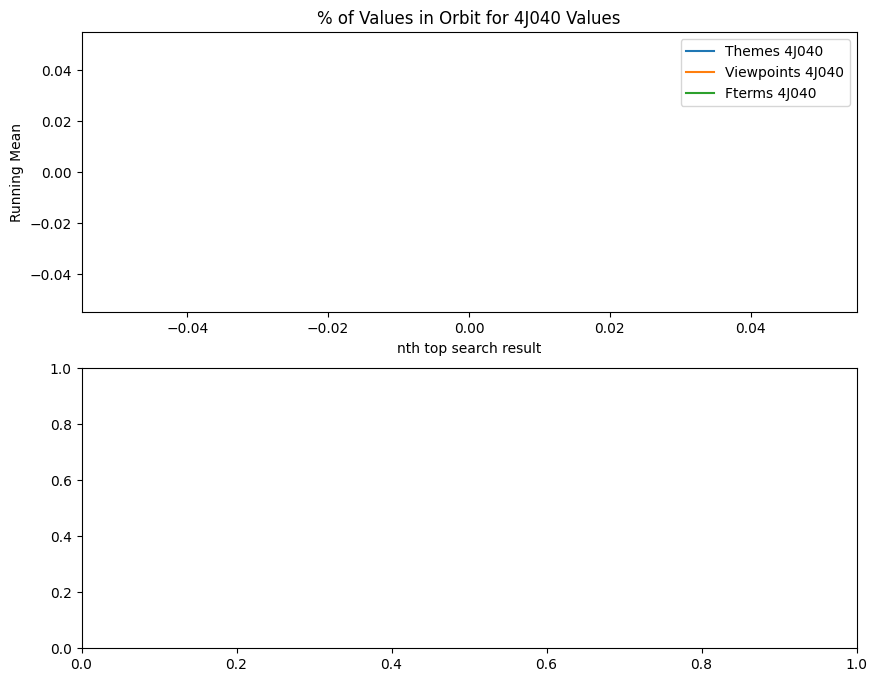

In [13]:
################################
# Plotting the results
################################

ma = 200

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

o_theme_4J040 = [1 if theme[:5] in orbit_themes else 0 for theme in themes_4J040]
o_theme_4F100 = [1 if theme[:5] in orbit_themes else 0 for theme in themes_4F100]

o_vp_4J040 = [1 if theme[:8] in orbit_viewpoints else 0 for theme in themes_4J040]
o_vp_4F100 = [1 if theme[:8] in orbit_viewpoints else 0 for theme in themes_4F100]

o_fterm_4J040 = [1 if theme[:10] in orbit_fterms else 0 for theme in themes_4J040]
o_fterm_4F100 = [1 if theme[:10] in orbit_fterms else 0 for theme in themes_4F100]

m_t_4J040 = running_mean(o_theme_4J040, ma)*100
m_t_4F100 = running_mean(o_theme_4F100, ma)*100

m_vp_4J040 = running_mean(o_vp_4J040, ma)*100
m_vp_4F100 = running_mean(o_vp_4F100, ma)*100

m_ft_4J040 = running_mean(o_fterm_4J040, ma)*100
m_ft_4F100 = running_mean(o_fterm_4F100, ma)*100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

bv_theme  = len(orbit_themes)/len(theme_dict)*100
bv_vp =  len(orbit_viewpoints)/len(viewpoint_dict)*100
bv_fterm = len(orbit_fterms)/len(number_dict)*100

# Plot the running mean lists for 4J040 values
ax1.plot(m_t_4J040, label='Themes 4J040')
ax1.plot(m_vp_4J040, label='Viewpoints 4J040')
ax1.plot(m_ft_4J040, label='Fterms 4J040')

ax1.set_title('% of Values in Orbit for 4J040 Values')
ax1.set_xlabel('nth top search result')
ax1.set_ylabel('Running Mean')
ax1.legend()

# Fit and plot trend lines for 4J040 values
x = np.arange(len(m_t_4J040))
m, b = np.polyfit(x, m_t_4J040, 1)
ax1.plot(x, m * x + b, '--', label=f'Trend Themes 4J040 (m={m:.2f})')

m, b = np.polyfit(x, m_vp_4J040, 1)
ax1.plot(x, m * x + b, '--', label=f'Trend Viewpoints 4J040 (m={m:.2f})')

m, b = np.polyfit(x, m_ft_4J040, 1)
ax1.plot(x, m * x + b, '--', label=f'Trend Fterms 4J040 (m={m:.2f})')

ax1.legend()

# Plot the running mean lists for 4F100 values
ax2.plot(m_t_4F100, label='Themes 4F100')
ax2.plot(m_vp_4F100, label='Viewpoints 4F100')
ax2.plot(m_ft_4F100, label='Fterms 4F100')
ax2.set_title('% of Values in Orbit for 4J040 Values')
ax2.set_xlabel('nth top search result')
ax2.set_ylabel('Running Mean')
ax2.legend()

# Fit and plot trend lines for 4F100 values
x = np.arange(len(m_t_4F100))
m, b = np.polyfit(x, m_t_4F100, 1)
ax2.plot(x, m * x + b, '--', label=f'Trend Themes 4F100 (m={m:.2f})')

m, b = np.polyfit(x, m_vp_4F100, 1)
ax2.plot(x, m * x + b, '--', label=f'Trend Viewpoints 4F100 (m={m:.2f})')

m, b = np.polyfit(x, m_ft_4F100, 1)
ax2.plot(x, m * x + b, '--', label=f'Trend Fterms 4F100 (m={m:.2f})')

ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

fig.savefig('Moving Average Recall of Orbit.png')
# Show the plot
plt.show()

In [ ]:
len(orbit_fterms)/len(number_dict), len(orbit_viewpoints)/len(viewpoint_dict), len(orbit_themes)/len(theme_dict)

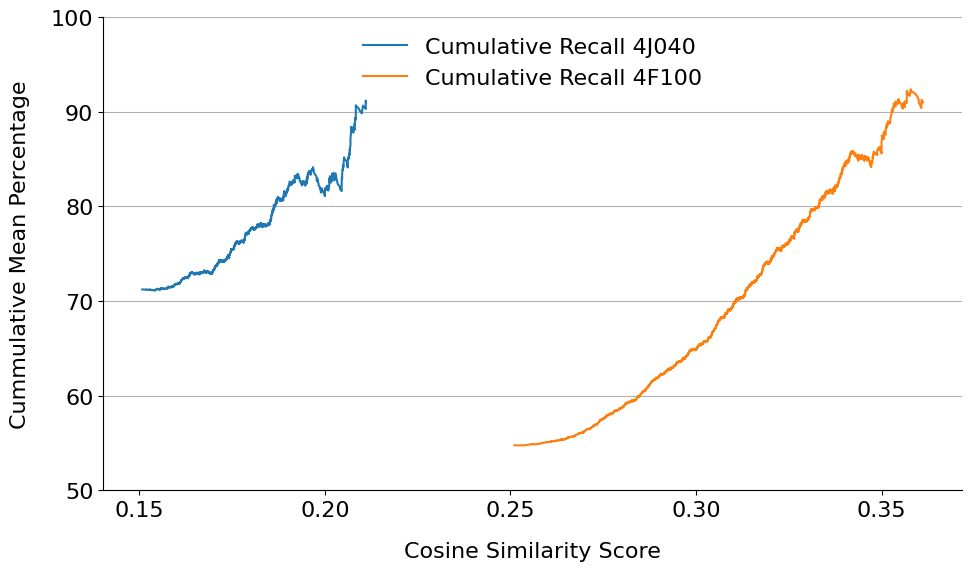

In [10]:
################################
# Plotting the results
################################

ma = 100
start= 100

# Set the font to Helvetica size 12
plt.rcParams['svg.fonttype'] = 'none'  # This will prevent text from being converted into paths in the SVG.
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 16

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def cumulation(x, start=start):
    out = [sum(x[:i])*100/i for i in range(start, len(x)+1)]
    return out
    

o_theme_4J040 = [1 if theme[:5] in orbit_themes else 0 for theme in themes_4J040]
o_theme_4F100 = [1 if theme[:5] in orbit_themes else 0 for theme in themes_4F100]

o_vp_4J040 = [1 if theme[:8] in orbit_viewpoints else 0 for theme in themes_4J040]
o_vp_4F100 = [1 if theme[:8] in orbit_viewpoints else 0 for theme in themes_4F100]

o_fterm_4J040 = [1 if theme[:10] in orbit_fterms else 0 for theme in themes_4J040]
o_fterm_4F100 = [1 if theme[:10] in orbit_fterms else 0 for theme in themes_4F100]


m_t_4J040 = cumulation(o_theme_4J040)
m_t_4F100 = cumulation(o_theme_4F100)

m_vp_4J040 = cumulation(o_vp_4J040)
m_vp_4F100 = cumulation(o_vp_4F100)

m_ft_4J040 = cumulation(o_fterm_4J040)
m_ft_4F100 = cumulation(o_fterm_4F100)

# Create a figure with two subplots
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

bv_theme  = len(orbit_themes)/len(theme_dict)*100
bv_vp =  len(orbit_viewpoints)/len(viewpoint_dict)*100
bv_fterm = len(orbit_fterms)/len(number_dict)*100

# Plot the running mean lists for 4J040 values
x = np.array(scores_4J040[start-1:])
#x = np.arange(len(m_t_4J040))
ax1.plot(x, m_t_4J040, label='Cumulative Recall 4J040')
#ax1.plot(x, m_vp_4J040, label='Viewpoints 4J040')
#ax1.plot(x, m_ft_4J040, label='Fterms 4J040')

#ax1.set_title('% of Values in Orbit for 4J040 Values')
ax1.set_xlabel('Cosine Similarity Score', labelpad=15)
ax1.set_ylabel('Cummulative Mean Percentage', labelpad=15)


x = np.array(scores_4F100[start-1:])
#x = np.arange(len(m_t_4F100))
ax1.plot(x, m_t_4F100, label='Cumulative Recall 4F100')

# Add horizontal gridlines at each 10% increment
ax1.yaxis.grid(True)
plt.yticks(np.arange(50, 101, 10))  # Adjust the y-ticks to start from 50 and go up in 10% increments

# Set y-axis to start from 50 and end at 100 (or another maximum value)
ax1.set_ylim([50, 100])

# Remove the top and right borders of the plot box
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Keep the x and y axes visible
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.legend(loc='upper center', frameon=False)

# Adjust spacing between subplots and show the plot
plt.tight_layout()
plt.savefig('Cumulative average.svg', format='svg', bbox_inches='tight')
plt.show()

In [54]:
search_theme = "4H006"

res_fterms = [(k,d)  for k, d in full_descriptions_dict.items() if k[:5] == search_theme]

for x in res_fterms:
    print(x)

('4H006/AA01', 'organic low-molecular-weight compounds and preparation thereoftype of invention. substances')
('4H006/AA02', 'organic low-molecular-weight compounds and preparation thereoftype of invention. methods of preparation (separation purification or stabilisation)')
('4H006/AA03', 'organic low-molecular-weight compounds and preparation thereoftype of invention. uses')
('4H006/AA04', 'organic low-molecular-weight compounds and preparation thereoftype of invention. apparatus')
('4H006/AA05', 'organic low-molecular-weight compounds and preparation thereoftype of invention. others (transport storage or decomposition)')
('4H006/AB01', 'organic low-molecular-weight compounds and preparation thereofuse. agricultural chemicals (fertilisers)')
('4H006/AB10', 'organic low-molecular-weight compounds and preparation thereofuse. food or feed materials (feed additives)')
('4H006/AB12', 'organic low-molecular-weight compounds and preparation thereofuse. cosmetics or shampoos')
('4H006/AB14', 

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
